In [1]:
cd drive/

/content/drive


In [2]:
cd My\ Drive

/content/drive/My Drive


In [3]:
cd Plate_detect_and_recognize-master/

/content/drive/My Drive/Plate_detect_and_recognize-master


In [4]:
# remove warning message
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'


# required library
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from utils import detect_lp
from os.path import splitext,basename
from keras.models import model_from_json
from keras.preprocessing.image import load_img, img_to_array
from keras.applications.mobilenet_v2 import preprocess_input
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
import glob
import math
import statistics
from operator import itemgetter

def load_model(path):
    try:
        path = splitext(path)[0]
        with open('%s.json' % path, 'r') as json_file:
            model_json = json_file.read()
        model = model_from_json(model_json, custom_objects={})
        model.load_weights('%s.h5' % path)
        print("Loading model successfully...")
        return model
    except Exception as e:
        print(e)


wpod_net_path = "wpod-net.json"
wpod_net = load_model(wpod_net_path)



def preprocess_image(image_path,resize=False):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255
    if resize:
        img = cv2.resize(img, (224,224))
    return img

def get_plate(image_path):
    Dmax = 608
    Dmin = 288
    vehicle = preprocess_image(image_path)
    ratio = float(max(vehicle.shape[:2])) / min(vehicle.shape[:2])
    side = int(ratio * Dmin)
    bound_dim = min(side, Dmax)
    _ , LpImg, _, cor = detect_lp(wpod_net, vehicle, bound_dim, lp_threshold=0.5)
    return vehicle, LpImg, cor

    

Loading model successfully...


In [14]:
def basic_method(plate_image):
    gray = cv2.cvtColor(plate_image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray,(7,7),0)
    
    binary = cv2.threshold(blur, 180, 255,
                         cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    
    kernel3 = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    thre_mor = cv2.morphologyEx(binary, cv2.MORPH_DILATE, kernel3)
    myBinary = cv2.threshold(gray, 180, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    return [plate_image, gray, blur, binary, thre_mor, myBinary]

def color_method(colorNumber, plate_image):
  possibleImages = []
  b = plate_image.copy()
  b = b[:, :, colorNumber]
  y = math.floor(b.shape[0]/2.4)
  x = math.floor(b.shape[1]/9)
  crop_img = b[y:int(y*2), x:int(x*8.3)]
  flatArray = b.flatten()
  cangeV =  np.percentile(flatArray, [32])
  image = cv2.cvtColor(b, cv2.COLOR_BGR2RGB)
  gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
  _, binary = cv2.threshold(gray, cangeV, cangeV, cv2.THRESH_BINARY_INV)


  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  
  blur = cv2.GaussianBlur(gray,(7,7),0)
  
  binary = cv2.threshold(blur, 180, 255,
                        cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
  
  kernel3 = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
  thre_mor = cv2.morphologyEx(binary, cv2.MORPH_DILATE, kernel3)
  myBinary = cv2.threshold(gray, 180, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
  return [plate_image, gray, blur, binary, thre_mor, myBinary]

def visualize_set(plot_image):
  # visualize results    
  fig = plt.figure(figsize=(12,7))
  plt.rcParams.update({"font.size":18})
  grid = gridspec.GridSpec(ncols=2,nrows=3,figure = fig)
  # plot_name = ["plate_image","gray","blur","binary","dilation"]

  for i in range(len(plot_image)):
      fig.add_subplot(grid[i])
      plt.axis(False)
      # plt.title(plot_name[i])
      plt.imshow(plot_image[i])

def myBlackAndWhite(plate_image):

  plate_image.convert('L')
  return plate_image
  # output = []
  # for row in plate_image:
  #   row = []
  #   for cell in row:
  #     average = sum(cell)/len(cell)
  #     cell = [average for cow in cell]
  #     row = row + append(cell)
  #   output = output + row

  return output

def myFilter(plate_image):
  trans1 = myBlackAndWhite(plate_image)

  # plate_image = cv2.convertScaleAbs(plate_image, alpha=(255.0))
  # trans1 = cv2.cvtColor(plate_image, cv2.COLOR_BGR2GRAY)

  # possibleImages = []
  # b = plate_image.copy()
  # b = b[:, :, colorNumber]
  # y = math.floor(b.shape[0]/2.4)
  # x = math.floor(b.shape[1]/9)
  # crop_img = b[y:int(y*2), x:int(x*8.3)]
  # flatArray = b.flatten()
  # cangeV =  np.percentile(flatArray, [32])
  # image = cv2.cvtColor(b, cv2.COLOR_BGR2RGB)
  # gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
  
  plt.imshow(trans1)


def getFilteredPlateImages(path):
  returnArray = []
  test_image_path = path
  vehicle, LpImg,cor = get_plate(test_image_path)
  
  filtered = myFilter(LpImg[0])

  # plt.imshow(LpImg[0])
  
  # print(len(LpImg))

  # if (len(LpImg)): #check if there is at least one license image
  #   # Scales, calculates absolute values, and converts the result to 8-bit.    
  #   plate_image = cv2.convertScaleAbs(LpImg[0], alpha=(255.0))
  #   returnArray.append(basic_method(plate_image))
  #   for i in range(3):
  #     returnArray.append(color_method(i,plate_image))
      
  # for im in returnArray:
  #   visualize_set(im)
  # return returnArray

# filteredPlateImages =  getFilteredPlateImages("Plate_examples/50States.jpg")
# filteredPlateImages =  getFilteredPlateImages("Plate_examples/germany_car_plate.jpg")
# filteredPlateImages =  getFilteredPlateImages("Plate_examples/photo2.JPG")
# filteredPlateImages = getFilteredPlateImages("Plate_examples/easy2.jpg")
filteredPlateImages =  getFilteredPlateImages("utahPlates/pol3.jpg")

AttributeError: ignored

In [22]:
from PIL import Image
def black_and_white_dithering(input_image_path,
    output_image_path,
    dithering=True):
    color_image = Image.open(input_image_path)
    if dithering:
        bw = color_image.convert('1')  
    else:
        bw = color_image.convert('1',
    dither=Image.NONE)
    
    plate_image = cv2.convertScaleAbs(color_image, alpha=(255.0))

    # plt.imshow(plate_image)

    # gray = cv2.cvtColor(plate_image, cv2.COLOR_BGR2GRAY)
    # blur = cv2.GaussianBlur(gray,(7,7),0)
    
    # binary = cv2.threshold(blur, 180, 255,
    #                      cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    
    # kernel3 = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    # thre_mor = cv2.morphologyEx(binary, cv2.MORPH_DILATE, kernel3)
    # myBinary = cv2.threshold(gray, 180, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    # return [plate_image, gray, blur, binary, thre_mor, myBinary]

if __name__ == '__main__':
    black_and_white_dithering(
        'utahPlates/1.jpg',
        'utahPlates/pol9.jpg')

TypeError: ignored

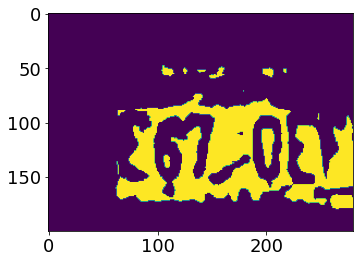

In [68]:
image = cv2.imread('utahPlates/8.jpg')


image[:, :, 0] = 0

image[:, :, 2] = 0


gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

i = 50

(thresh, blackAndWhiteImage) = cv2.threshold(gray, 110, 255, cv2.THRESH_BINARY)
plt.imshow(blackAndWhiteImage)
